In [1]:
import sys
sys.path.append('../../')

from amplify.client import FixstarsClient
import numpy as np
import os

from flow_solver.finite_element_model import FEM
from flow_solver.mesh_generator import MeshDiffuser
from optimizer import Annealing, AnnealingSolver, PolyTop
from problems.topo_opt_level_set_fluid_flow import TopologyOptimizationProblem

# Topology Optimization for Diffuser Problem

## Computational Mesh

In [2]:
# Create Meshes for Diffuser Problem.
n_elem_for_width = 32
n_elem_for_height = 32
mesh_v = MeshDiffuser('Q2', n_elem_for_width, n_elem_for_height, width=1., height=1., outlet_height=1./3.)
mesh_p = MeshDiffuser('Q1', n_elem_for_width, n_elem_for_height, width=1., height=1., outlet_height=1./3.)

## Finite Element Model

### Boundary Conditions

In [3]:
def inlet_velocity(mesh, i_node):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 4*(1.-y)*y; v_y = 0.0
    return np.array([v_x, v_y])

In [4]:
def outlet_velocity(mesh, i_node, width):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 0.0; v_y = 0.0
    return np.array([v_x,v_y])

In [5]:
# Compute boundary velocities.
boundary_velocity = {key: [] for key in mesh_v.boundary_nodes.keys()}
for boundary in mesh_v.boundary_nodes.keys():
    for i_node in mesh_v.boundary_nodes[boundary]:
        if boundary == 'inlet':
            boundary_velocity[boundary].append(inlet_velocity(mesh_v, i_node))
        elif boundary == 'wall':
            boundary_velocity[boundary].append(np.zeros(2))

# Set values for Dirichlet boundary conditions.
# Velocity.
BC = []
for boundary in mesh_v.boundary_nodes.keys():
    for i_node, node in enumerate(mesh_v.boundary_nodes[boundary]):
        if boundary == 'inlet' or boundary == 'wall' :
            BC.append([node, 0, boundary_velocity[boundary][i_node][0]])
            BC.append([node, 1, boundary_velocity[boundary][i_node][1]])
        elif boundary == 'outlet':
            # Parallel outflow, i.e., no vertical velocity.
            BC.append([node, 1, 0.0])
boundary_values_v = np.array(BC)

### Material Properties

In [6]:
viscosity = 1. 
density = 1.

# 
epsilon = 8.e-2

### Finite Element Model

In [7]:
fem = FEM(mesh_v, mesh_p, viscosity, density, epsilon)
fem.set_boudary_values_v(boundary_values_v)

Objective Function:0.0028356281238802027


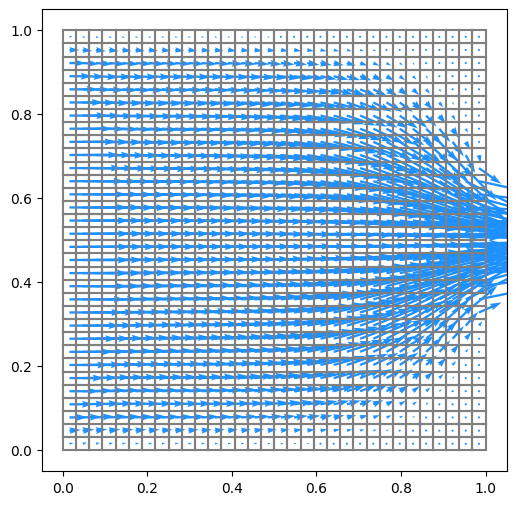

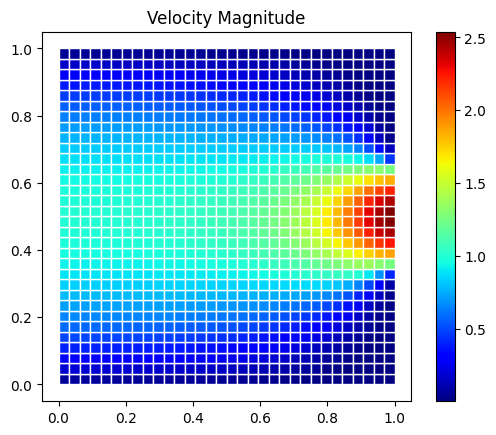

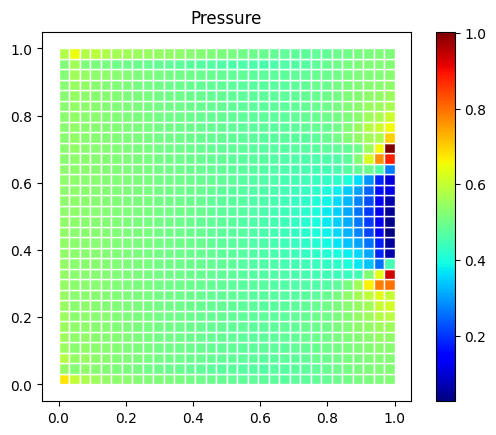

In [8]:
U, u_e, v_e, p_e, F, f=fem.solve()
print(f'Objective Function:{f}')
fem.plot_velocity_field([u_e, v_e])
fem.plot_velocity_magnitude([u_e, v_e])
fem.plot_pressure(p_e)

## Optimization

In [9]:
# Settings for Optimization.
volume_fraction_max = 0.5 # Volume fraction.
tolerance = 0.01 # Convergence tolerance on design variables.

### Optimization with Ising Machine Formulation

In [10]:
# Annealing Solver.
client = FixstarsClient()
client.parameters.timeout = 1000
client.parameters.outputs.duplicate = True
if os.path.exists('token_Fixstars.txt'):
    client.token = open('token_Fixstars.txt',"r").read().replace('\n', '')
if os.path.exists('proxy.txt'):
    client.proxy = open('proxy.txt',"r").read().replace('\n', '')

annealing_solver = AnnealingSolver(client)

In [11]:
# Topology Optimization Problem in Ising Machine Formulation.
n_qubits_per_variable = 9

hyperparameters = {
        'energy_dissipation': 3.e3,
        'regularization': 50.,
        'volume_constraint': 600.,
        'char_func': 300.
}

topo_opt_problem = TopologyOptimizationProblem(fem.ne, n_qubits_per_variable, hyperparameters, volume_fraction_max)
topo_opt_problem.generate_discretizaton()

Iteration: 0, Objective Function: 0.025325045455265614, Volume Fraction: 0.513671875, Inconsistencies: 0
Abs. change in
	char. func.:498.0
Rel. change in
	char. func.:0.486328125
	Obj. func.: 7.931017872897752
Iteration: 1, Objective Function: 0.012706106751322542, Volume Fraction: 0.501953125, Inconsistencies: 0
Abs. change in
	char. func.:42.0
Rel. change in
	char. func.:0.07984790874524715
	Obj. func.: 0.49827901498669674
Iteration: 2, Objective Function: 0.011051360128274634, Volume Fraction: 0.5009765625, Inconsistencies: 0
Abs. change in
	char. func.:13.0
Rel. change in
	char. func.:0.02529182879377432
	Obj. func.: 0.1302323878929847
Iteration: 3, Objective Function: 0.010502552818123657, Volume Fraction: 0.5009765625, Inconsistencies: 0
Abs. change in
	char. func.:6.0
Rel. change in
	char. func.:0.011695906432748537
	Obj. func.: 0.049659707382701805
Iteration: 4, Objective Function: 0.010196273189576792, Volume Fraction: 0.5009765625, Inconsistencies: 0
Abs. change in
	char. fun

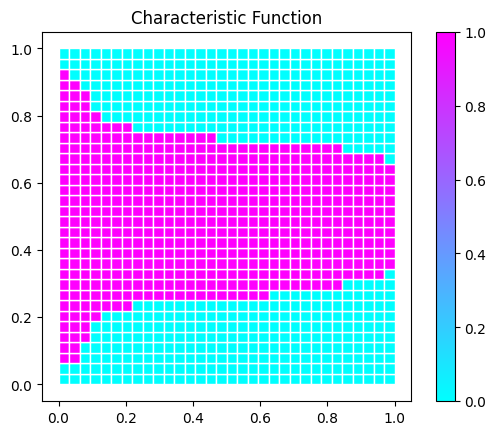

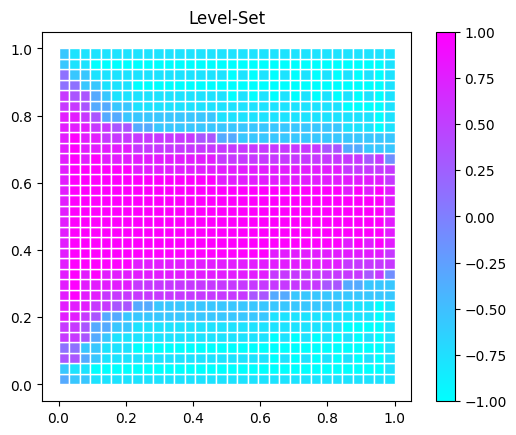

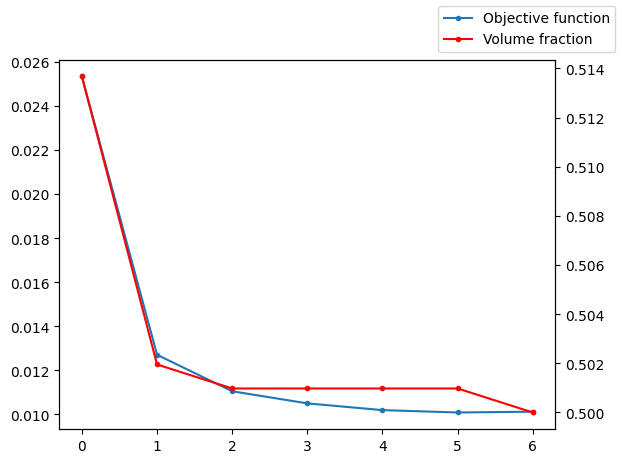

In [12]:
# Optimization
max_opt_steps = 15
# Initial scaled level-set values, i.e., design variables, for each element.
level_set_scaled_initial = np.ones(mesh_v.n_elem) 
annealing_optimizer = Annealing(fem)

annealing_optimizer.optimize(annealing_solver,
                        topo_opt_problem, 
                        level_set_scaled_initial,
                        max_opt_steps,
                        tolerance,
                        plot_steps=False)
annealing_optimizer.plot_history()

In [13]:
hyperparameters = {
        'energy_dissipation': 1.,
        'regularization': 0.,
        'volume_constraint': 0.15,
        'char_func': 0.
}
topo_opt_problem.set_hyperparameters(hyperparameters)

Iteration: 0, Objective Function: 0.02389294755017874, Volume Fraction: 0.517578125, Inconsistencies: 494
Abs. change in
	char. func.:494.0
Rel. change in
	char. func.:0.482421875
	Obj. func.: 7.425980596314663
Iteration: 1, Objective Function: 0.012066285790189549, Volume Fraction: 0.501953125, Inconsistencies: 510
Abs. change in
	char. func.:46.0
Rel. change in
	char. func.:0.08679245283018867
	Obj. func.: 0.49498546527804677
Iteration: 2, Objective Function: 0.011016256560329177, Volume Fraction: 0.5009765625, Inconsistencies: 511
Abs. change in
	char. func.:9.0
Rel. change in
	char. func.:0.017509727626459144
	Obj. func.: 0.08702174373443847
Iteration: 3, Objective Function: 0.010479079406102787, Volume Fraction: 0.5009765625, Inconsistencies: 511
Abs. change in
	char. func.:6.0
Rel. change in
	char. func.:0.011695906432748537
	Obj. func.: 0.04876222256486179
Iteration: 4, Objective Function: 0.01021531667967222, Volume Fraction: 0.5009765625, Inconsistencies: 511
Abs. change in
	c

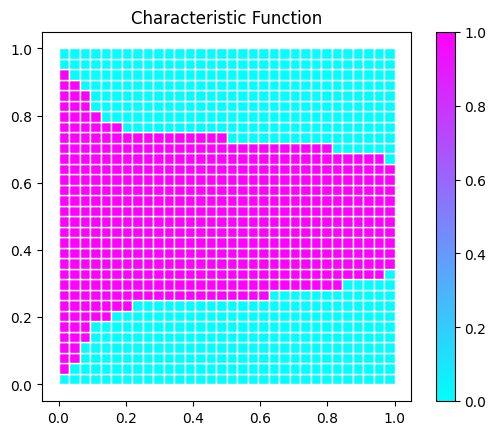

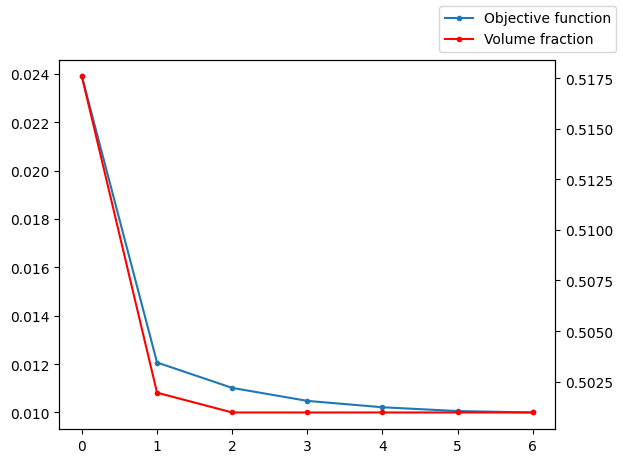

In [14]:
annealing_optimizer.optimize(annealing_solver,
                            topo_opt_problem, 
                            level_set_scaled_initial,
                            max_opt_steps,
                            tolerance,
                            plot_steps=False)
annealing_optimizer.plot_history()